<a href="https://colab.research.google.com/github/Avniiii2606/Email-Classification-using-BERT-LDA/blob/main/Multi_class_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip show requests

Name: requests
Version: 2.32.3
Summary: Python HTTP for Humans.
Home-page: https://requests.readthedocs.io
Author: Kenneth Reitz
Author-email: me@kennethreitz.org
License: Apache-2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: certifi, charset-normalizer, idna, urllib3
Required-by: bigframes, CacheControl, community, diffusers, earthengine-api, fastai, folium, gcsfs, gdown, geocoder, google-api-core, google-cloud-bigquery, google-cloud-storage, google-colab, google-genai, huggingface-hub, kaggle, kagglehub, langchain, langsmith, moviepy, music21, pandas-datareader, panel, pooch, pymystem3, requests-oauthlib, requests-toolbelt, spacy, Sphinx, tensorflow, tensorflow-datasets, transformers, tweepy, wandb, weasel, yfinance


In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from huggingface_hub import snapshot_download
import warnings
warnings.filterwarnings('ignore')

# Download BERT model files
model_name = "bert-base-uncased"
cache_dir = "./bert_model"

try:
    snapshot_download(repo_id=model_name, cache_dir=cache_dir)
except:
    print("Model files already downloaded")

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/491 [00:00<?, ?B/s]

(…)kage/Data/com.apple.CoreML/model.mlmodel:   0%|          | 0.00/165k [00:00<?, ?B/s]

LICENSE:   0%|          | 0.00/11.4k [00:00<?, ?B/s]

flax_model.msgpack:   0%|          | 0.00/438M [00:00<?, ?B/s]

weight.bin:   0%|          | 0.00/532M [00:00<?, ?B/s]

(…)sk/float32_model.mlpackage/Manifest.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

rust_model.ot:   0%|          | 0.00/534M [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/536M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/532M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
class TicketDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Check if idx is within the bounds of self.texts
        if idx >= len(self.texts):
            # Handle the error, e.g., by raising an IndexError
            raise IndexError(f"Index {idx} is out of bounds for dataset with length {len(self.texts)}")

        text = str(self.texts.iloc[idx]) # Access using iloc for integer location
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
class BertClassifier(nn.Module):
    def __init__(self, n_classes):
        super(BertClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained('bert-base-uncased', cache_dir=cache_dir)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs.pooler_output
        dropout_output = self.dropout(pooled_output)
        return self.classifier(dropout_output)


In [ ]:
def load_and_preprocess_data(file_path):
    # Load dataset
    df = pd.read_csv(file_path)

    # Combine title and description for better classification
    df['text'] = df['Topic_group'] + df['Document']

    # Encode labels
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(df['Topic_group'])

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        df['text'],
        labels,
        test_size=0.2,
        random_state=42,
        stratify=labels
    )

    return X_train, X_test, y_train, y_test, label_encoder.classes_

In [ ]:
def train_epoch(model, data_loader, optimizer, criterion, device, num_epochs, epoch): # Add num_epochs as an argument
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for batch in tqdm(data_loader, desc="Training"):
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)

        _, predictions = torch.max(outputs, dim=1)
        correct_predictions += torch.sum(predictions == labels)
        total_predictions += len(labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    accuracy = correct_predictions.double() / total_predictions

    # Save model inside the train_epoch function using the provided num_epochs and epoch values
    model_save_path = f"bert_ticket_classifier_epoch_{epoch + 1}.pt"
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved after epoch {epoch + 1} to '{model_save_path}'")

    return total_loss / len(data_loader), accuracy

In [ ]:
def evaluate_model(model, data_loader, criterion, device, class_names):
    model.eval()
    total_loss = 0
    predictions_list = []
    labels_list = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            _, predictions = torch.max(outputs, dim=1)

            predictions_list.extend(predictions.cpu().numpy())
            labels_list.extend(labels.cpu().numpy())
            total_loss += loss.item()

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(labels_list, predictions_list, target_names=class_names))

    # Plot confusion matrix
    plt.figure(figsize=(12, 8))
    cm = confusion_matrix(labels_list, predictions_list)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    return total_loss / len(data_loader), predictions_list, labels_list

In [ ]:
def train_and_evaluate(X_train, X_test, y_train, y_test, class_names):
    # Initialize tokenizer and create datasets
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', cache_dir=cache_dir)
    train_dataset = TicketDataset(X_train, y_train, tokenizer)
    test_dataset = TicketDataset(X_test, y_test, tokenizer)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16)

    # Initialize model and training parameters
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = BertClassifier(len(class_names)).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    criterion = nn.CrossEntropyLoss()
    num_epochs = 3

    print(f"Training on {device}")

    # Training loop
    for epoch in range(num_epochs):
        avg_train_loss, train_accuracy = train_epoch(
            model, train_loader, optimizer, criterion, device, num_epochs, epoch # Pass num_epochs and epoch
        )
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Average Training Loss: {avg_train_loss:.4f}")
        print(f"Training Accuracy: {train_accuracy:.4f}")


    # Evaluation
    test_loss, predictions, labels = evaluate_model(
        model, test_loader, criterion, device, class_names
    )

    return model, predictions


In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

def evaluate_validation_accuracy(model_path, X_test, y_test, tokenizer, class_names, batch_size=32, device=None): # Add tokenizer and class_names as arguments
    """
    Evaluates the model's accuracy on a validation dataset.

    Args:
        model_path (str): Path to the saved model file.
        X_test (pd.Series): The text data for validation.
        y_test (np.ndarray): The corresponding labels for validation.
        tokenizer (transformers.AutoTokenizer): The tokenizer used for the model.
        class_names (list): List of class names for the classification task.
        batch_size (int, optional): Batch size for validation. Defaults to 32.
        device (torch.device, optional): Device to use for evaluation. Defaults to None.

    Returns:
        float: Validation accuracy.
    """

    # Create validation dataset
    validation_dataset = TicketDataset(X_test, y_test, tokenizer) # Use the passed tokenizer

    # Set device
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load the model
    model = BertClassifier(len(class_names)) # Use the passed class_names
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()  # Set model to evaluation mode

    # Prepare DataLoader
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

    # Initialize counters
    correct_predictions = 0
    total_predictions = 0

    # Evaluation loop
    with torch.no_grad():
        for batch in validation_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

    # Calculate accuracy
    accuracy = 100.0 * correct_predictions / total_predictions
    return accuracy

In [ ]:
def predict_text_input(texts, model_path, class_names, cache_dir='./cache'):

    # Load tokenizer and device
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', cache_dir=cache_dir)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Define the model structure (same as during training)


    # Load the trained model
    model = BertClassifier(len(class_names))
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    # Process input texts
    results = []
    for text in texts:
        # Tokenize the input text
        encoding = tokenizer(
            text,
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        # Make predictions
        with torch.no_grad():
            outputs = model(input_ids, attention_mask)
            probabilities = torch.softmax(outputs, dim=1)
            confidence, predicted_class_idx = torch.max(probabilities, dim=1)

        predicted_class = class_names[predicted_class_idx.item()]
        results.append((text, predicted_class, confidence.item()))

    return results

Training on cuda


Training: 100%|██████████| 2392/2392 [13:14<00:00,  3.01it/s]


Model saved after epoch 1 to 'bert_ticket_classifier_epoch_1.pt'
Epoch 1/3
Average Training Loss: 0.0665
Training Accuracy: 0.9830


Training: 100%|██████████| 2392/2392 [13:13<00:00,  3.02it/s]


Model saved after epoch 2 to 'bert_ticket_classifier_epoch_2.pt'
Epoch 2/3
Average Training Loss: 0.0005
Training Accuracy: 1.0000


Training: 100%|██████████| 2392/2392 [13:13<00:00,  3.01it/s]


Model saved after epoch 3 to 'bert_ticket_classifier_epoch_3.pt'
Epoch 3/3
Average Training Loss: 0.0001
Training Accuracy: 1.0000


Evaluating: 100%|██████████| 598/598 [01:04<00:00,  9.27it/s]



Classification Report:
                       precision    recall  f1-score   support

               Access       1.00      1.00      1.00      1425
Administrative rights       1.00      1.00      1.00       352
           HR Support       1.00      1.00      1.00      2183
             Hardware       1.00      1.00      1.00      2724
     Internal Project       1.00      1.00      1.00       424
        Miscellaneous       1.00      1.00      1.00      1412
             Purchase       1.00      1.00      1.00       493
              Storage       1.00      1.00      1.00       555

             accuracy                           1.00      9568
            macro avg       1.00      1.00      1.00      9568
         weighted avg       1.00      1.00      1.00      9568



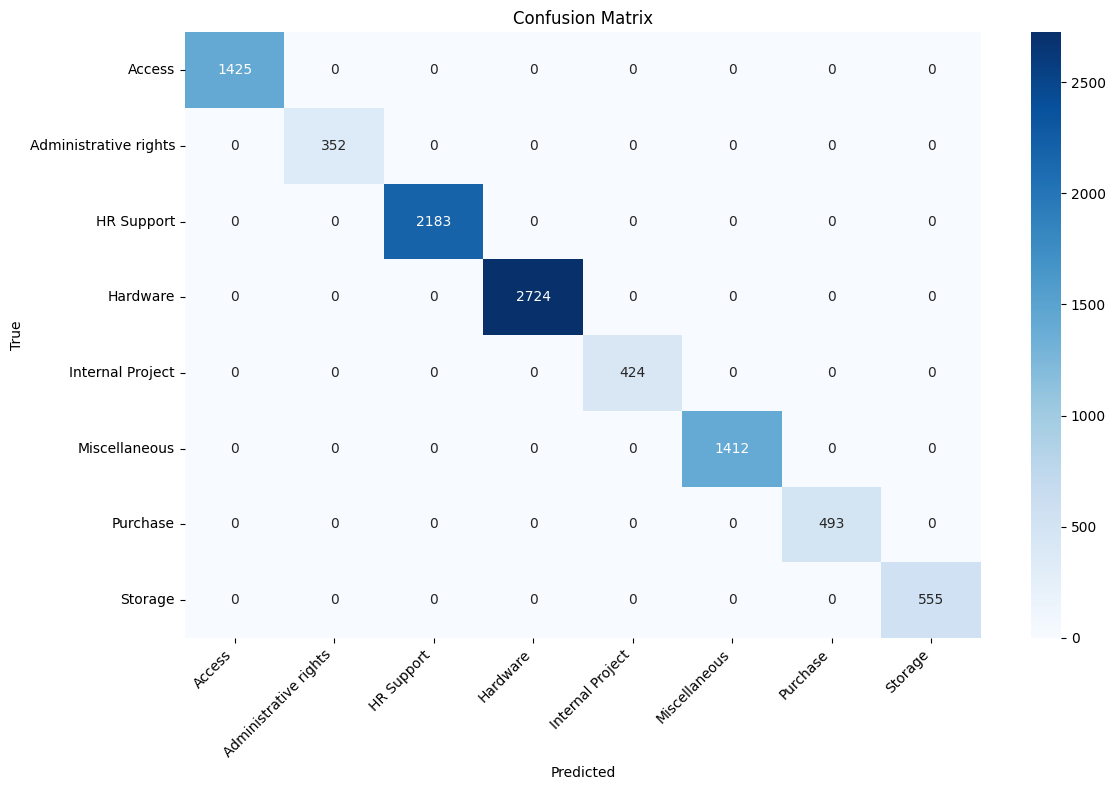


Model saved to 'bert_ticket_classifier.pt'
Validation Accuracy: 100.00%


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Text: The application is crashing when I click submit.
Predicted Class: Hardware (Confidence: 0.89)

Text: Need to reset my password.
Predicted Class: Miscellaneous (Confidence: 0.93)



In [ ]:
def main():
    # Set random seed for reproducibility
    torch.manual_seed(42)

    # Load and preprocess data
    file_path = '/content/drive/MyDrive/multi_class_text_dataset.csv'
    X_train, X_test, y_train, y_test, class_names = load_and_preprocess_data(file_path)

    # Train and evaluate model
    model, predictions = train_and_evaluate(X_train, X_test, y_train, y_test, class_names)

    # Save the model
    torch.save(model.state_dict(), 'bert_ticket_classifier.pt')
    print("\nModel saved to 'bert_ticket_classifier.pt'")

     # Initialize tokenizer here
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', cache_dir=cache_dir) # Initialize tokenizer

    # Call evaluate_validation_accuracy after training and before saving the model:
    model_path = "bert_ticket_classifier.pt"
    accuracy = evaluate_validation_accuracy(model_path, X_test, y_test, tokenizer=tokenizer, class_names=class_names)
    print(f"Validation Accuracy: {accuracy:.2f}%")


    test_texts = ["The application is crashing when I click submit.", "Need to reset my password."]
    class_names = ["Hardware", "HR Support", "Access", "Miscellaneous", "Storage", "Purchase", "Internal Project", "Administrative rights"]

    # Path to the saved model
    model_path = 'bert_ticket_classifier.pt'

    # Get predictions
    predictions = predict_text_input(test_texts, model_path, class_names)

    # Print predictions
    for text, predicted_class, confidence in predictions:
      print(f"Text: {text}")
      print(f"Predicted Class: {predicted_class} (Confidence: {confidence:.2f})\n")


if __name__ == "__main__":
    main()